In [2]:
using Revise
using QuanticsTCI
using SparseIR
import SparseIR: valueim
using ITensors
import TensorCrossInterpolation as TCI
using LinearAlgebra
import MSSTA
using PyPlot
using PyCall
using JLD2
using FileIO
ITensors.disable_warn_order()

14

In [20]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 10
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.serif"] = ["Computer Modern Roman"]

1-element Vector{String}:
 "Computer Modern Roman"

In [4]:
prefix = "haldane"

"haldane"

In [5]:
function tobins(i, nbit)
    @assert 1 ≤ i ≤ 2^nbit
    mask = 1 << (nbit-1)
    bin = ones(Int, nbit)
    for n in 1:nbit
        bin[n] = (mask & (i-1)) >> (nbit-n) + 1
        mask = mask >> 1
    end
    return bin
end

function frombins(bin)
    @assert all(1 .≤ bin .≤ 2)
    nbit = length(bin)
    i = 1
    tmp = 2^(nbit-1)
    for n in eachindex(bin)
        i += tmp * (bin[n] -1)
        tmp = tmp >> 1
    end
    return i
end

@assert frombins(tobins(4, 10)) == 4

function genfunc(t2, ϕ, m, β, μ)
    BZedgex = 4pi / 3
    BZedgey = 8pi / (3sqrt(3))
    function gkb(b)
        nbit = length(b) ÷ 2
        N = 2^nbit
        dkx = 2*BZedgex/N
        dky = 2*BZedgey/N
        ikx = frombins(b[1:2:end])
        iky = frombins(b[2:2:end])
        k = [dkx * (ikx-1) - BZedgex, dky * (iky-1) - BZedgey]
        return ghaldane(k, t2, ϕ, m, β, μ)
    end
end

function gengkdata(gkb, nbit)
    N = 2^nbit
    gkdata = zeros(ComplexF64, N, N)
    for ikx in 1:N, iky in 1:N
        bx = tobins(ikx, nbit)
        by = tobins(iky, nbit)
        b = collect(Iterators.flatten(zip(bx, by)))
        gkdata[ikx, iky] = gkb(b)
    end
    return gkdata
end

gengkdata (generic function with 1 method)

In [6]:
antisymmetricproduct(u, v) = u[1] * v[2] - u[2] * v[1]
    
function haldane(k, t2, ϕ, m)
    pauli0 = [1. 0.; 0. 1.]
    pauli = [
        [0. 1.; 1. 0.],
        [0. -1.0im; 1.0im 0.],
        [1. 0.; 0. -1.]
    ]

    a::Vector{Vector{Float64}} =
    [
        [1, 0],
        [-0.5, 0.5sqrt(3)],
        [-0.5, -0.5sqrt(3)]
    ]
    b::Vector{Vector{Float64}} = [a[2] - a[3], a[3] - a[1], a[1] - a[2]]

    return 2 * t2 * cos(ϕ) * sum(cos(k' * bi) for bi in b) * pauli0 +    # NNN hopping
        sum(cos(k' * ai) * pauli[1] + sin(k' * ai) * pauli[2] for ai in a) + # NN hopping
        (m - 2 * t2 * sin(ϕ) * sum(sin(k' * bi) for bi in b)) * pauli[3]    # staggered offset
end

function ghaldane(k, t2, ϕ, m, β, μ)
    ek = eigvals(haldane(k, t2, ϕ,m))
    iv = SparseIR.valueim(SparseIR.FermionicFreq(1), β)
    return sum(1 ./ (iv .- ek .+ μ))
end

ghaldane (generic function with 1 method)

In [7]:
deltam = -0.001

t2 = 0.1 #0.1
phi = pi/2
m = 3sqrt(3) * t2 + deltam

μ = 1.0

1.0

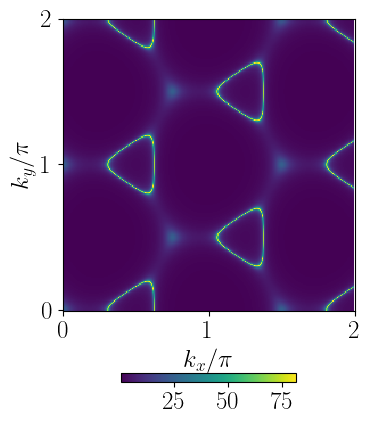

In [8]:
gkdata = gengkdata(genfunc(t2, phi, m, 256.0, μ), 8)

x = LinRange(0.0, 2.0, size(gkdata, 1)+1)[1:end-1]

plt[:pcolormesh](x, x, abs.(gkdata), rasterized=true)
ax = plt.gca().set_aspect("equal")
xlabel(L"k_x/\pi")
ylabel(L"k_y/\pi")
xticks([0, 1, 2])
yticks([0, 1, 2])
colorbar(shrink=0.3, location="bottom")

tight_layout()
savefig(prefix * "_gk.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())

In [9]:
#betas = [1.0, 4.0, 16.0, 64.0, 128.0]
betas = Float64[4.0, 16.0, 64.0, 128.0, 256.0, 512.0, 1024.0]
tols = [1e-5]
#nbits = [12, 16, 20]
#nbits = [12, 14, 16]
nbits = [10, 20, 30]

3-element Vector{Int64}:
 10
 20
 30

In [10]:
sites_nbit = Dict()
for nbit in nbits
    sitesx =  [Index(2, "Qubit,kx=$k") for k in 1:nbit]
    sitesy =  [Index(2, "Qubit,ky=$k") for k in 1:nbit]
    sites = collect(Iterators.flatten(zip(sitesx, sitesy)))
    sites_nbit[nbit] = sites
end

## QTCI

In [11]:
maxiter = 10000
BLAS.set_num_threads(16)

qtts = Dict()
qtt_ranks = Dict()

for tol in tols
    for beta in betas
        for nbit in nbits
            @show tol, beta, nbit
            bx_ = tobins(1, nbit)
            by_ = tobins(2^(nbit-1), nbit)
            func = genfunc(t2, phi, m, beta, μ)
            firstpivot = TCI.optfirstpivot(func, fill(2, 2*nbit))
            qtt, ranks, errors = TCI.crossinterpolate(
                ComplexF64, func, fill(2, 2*nbit),
                firstpivot, tolerance=tol, maxiter=maxiter, verbosity=1,
                pivottolerance=tol
            )
            qtts[(beta,nbit,tol)] = qtt
            qtt_ranks[(beta,nbit,tol)] = ranks
        end
    end
end

(tol, beta, nbit) = (1.0e-5, 4.0, 10)
rank= 10 , error= 0.48042524151507726
rank= 20 , error= 0.005995594626474658
rank= 30 , error= 0.0006749670732899302
rank= 40 , error= 4.732094484659312e-5
(tol, beta, nbit) = (1.0e-5, 4.0, 20)
rank= 10 , error= 0.47598239896141464
rank= 20 , error= 0.005170670965327067
rank= 30 , error= 0.0008972012176731516
rank= 40 , error= 3.527487401009119e-5
(tol, beta, nbit) = (1.0e-5, 4.0, 30)
rank= 10 , error= 0.47598239896141464
rank= 20 , error= 0.005170670965327067
rank= 30 , error= 0.0008972012176731516
rank= 40 , error= 3.527487401009119e-5
(tol, beta, nbit) = (1.0e-5, 16.0, 10)
rank= 10 , error= 1.1784997732357738
rank= 20 , error= 0.12681919202810674
rank= 30 , error= 0.009282648362628433
rank= 40 , error= 0.001937403496114065
rank= 50 , error= 0.00027589711925737073
rank= 60 , error= 3.839345495916947e-5
(tol, beta, nbit) = (1.0e-5, 16.0, 20)
rank= 10 , error= 1.1784997732357738
rank= 20 , error= 0.1423858766677735
rank= 30 , error= 0.0142946387745

rank= 250 , error= 0.058911672428508484
rank= 260 , error= 0.033425510922937184
rank= 270 , error= 0.015689531177131986
rank= 280 , error= 0.012220244876897674
rank= 290 , error= 0.008720691660955238
rank= 300 , error= 0.005868268247500333
rank= 310 , error= 0.004078192445680285
rank= 320 , error= 0.002282446169608501
rank= 330 , error= 0.0020098369880754033
rank= 340 , error= 0.0013740704156201251
rank= 350 , error= 0.000955451121645827
rank= 360 , error= 0.0006019155711811717
rank= 370 , error= 0.00045264899407470877
rank= 380 , error= 0.00026040855200410064
rank= 390 , error= 0.00012574943403523416
rank= 400 , error= 9.058951251740034e-5
rank= 410 , error= 9.261023217253206e-5
rank= 420 , error= 5.581574080198524e-5
rank= 430 , error= 5.0094453187625426e-5
rank= 440 , error= 2.9603931804102733e-5
rank= 450 , error= 2.813613136173582e-5
rank= 460 , error= 1.8902751523788553e-5
rank= 470 , error= 1.220632486706442e-5
(tol, beta, nbit) = (1.0e-5, 1024.0, 30)
rank= 10 , error= 120.95029

In [12]:
countnelem(M::MPS) = sum([prod(size(M[n])) for n in 1:length(M)])

countnelem (generic function with 1 method)

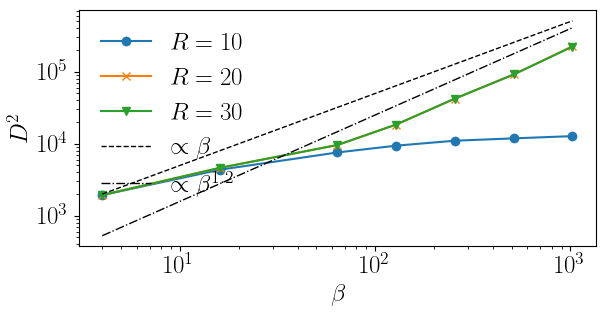

In [13]:
fig = figure(figsize=(6.4, 3.5))

tol = tols[end]

markers = ["o", "x", "v"]

for (i, nbit) in enumerate(nbits)
    ranks = [TCI.rank(qtts[(beta,nbit,tol)]) for beta in betas]
    loglog(betas, ranks .^ 2, marker=markers[i], label=L"R=%$(nbit)")
end

loglog(betas, 5e+2 * betas, label=L"\propto \beta", ls="--", color="k", lw=1.0)
loglog(betas, 1e+2 * betas .^ 1.2, label=L"\propto \beta^{1.2}", ls="-.", color="k", lw=1.0)
#loglog(betas, 1e+4 * betas .^ 0.5, label=L"\propto \beta^{1/2}", ls="-.", color="k", lw=1.0)

xlabel(L"\beta")
ylabel(L"D^2")
#xlim([0, 250])
#ylim([1e-7, 1e-1])
legend(frameon=false)

tight_layout()
#savefig(prefix * "_gk_rank_scaling_tol$(tol).pdf", bbox_inches="tight", transparent=true, rasterized=true)
#savefig("dyson3.pdf", bbox_inches="tight", transparent=true, rasterized=true)

display(gcf())
close(gcf())
    

In [14]:
tmp = Dict()
tmp["params"] = collect(keys(qtts))
for (beta, R, tol) in keys(qtts)
    tmp["$(beta) $(R) $(tol)"] = qtts[(beta, R, tol)]
end
save(prefix * "_gk_rank_scaling_tol$(tol).jld2", tmp)

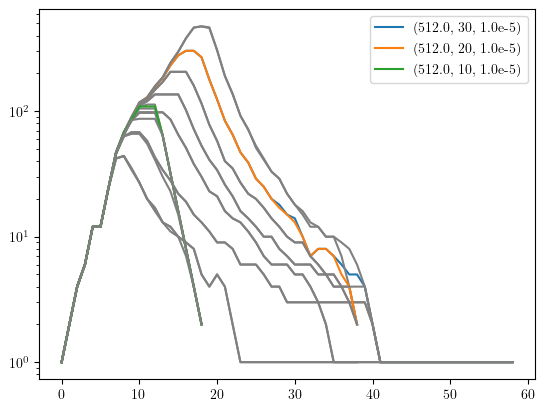

PyObject <matplotlib.legend.Legend object at 0x16f774b50>

In [22]:
for (key, value) in qtts
    if(key[1] != 512)
        semilogy(TCI.linkdims(value), "gray")
    else
        semilogy(TCI.linkdims(value), label="$key")
    end
end
legend()

In [16]:
nc = 1
fig = figure(figsize=(6.4, nc*2.8))
pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

annotate("(d)", xycoords="axes fraction", xy=(-0.2,0.92), fontsize=21)
maxL = 1

annotate(L"\beta=%$(Int(betas[end]))", xycoords="axes fraction", xy=(0.01,0.85), fontsize=18)
for (i, nbit) in enumerate(nbits)
    key = (betas[end], nbit, tols[end])
    mps = MSSTA.TCItoMPS(qtts[key])
    y = dim.(linkinds(mps))
    x = 1:length(y)
    maxL = max(maxL, length(y))
    semilogy(x, dim.(linkinds(mps)), marker=markers[i], c=pcolors[i], label=L"N=%$(Int(nbit))", ls=ls[i])
    if i == length(nbits)
        maxy = MSSTA.maxlinkdims(siteinds(mps))
        semilogy(x, maxy, marker="", c="gray", label="", ls="--")
    end
end

#ticker = matplotlib["ticker"]
#plt.axes().yaxis.set_minor_locator(ticker[:MultipleLocator](5))

xlabel(L"l")
xticks(0:5:maxL, fontsize=18)
ylabel(L"D_l")
ylim([1, 1000])
legend(frameon=false, fontsize=16, loc="upper right")

tight_layout()

savefig("dyson-d.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())

LoadError: InterruptException: